## Import packages

In [1]:
import numpy as np
import pandas as pd
import gc, random, math, time

In [2]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, SpatialDropout1D, BatchNormalization, RepeatVector, Lambda
from keras.layers.merge import concatenate, multiply, dot, Concatenate
from keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, TimeDistributed
from keras.models import Model, Sequential
from keras import optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras import backend as K
from keras.preprocessing import sequence, text
from keras import optimizers

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import KFold

## Hyper parameter setting

In [4]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen_p = 150 # max number of words in a context to use
maxlen_q = 10 # max number of words in a question to use
batch_size = 128
num_rnn_units = 32
num_hidden_units = 200
drop_prob = 0.5
max_norm = 5.0
mp = 3
features = 2

## File path

In [5]:
train_path = './data/train.tsv' # train set
valid_path = './data/valid.tsv' # validation set
test_path = './data/test.tsv' # test set
embed_file = './sgns.target.word-ngram.1-2.dynwin5.thr10.neg5.dim300.iter5' # 预训练词向量
fasttext_file = './cc.zh.300.vec' # 预训练词向量
train_feature_path = './data/train_fea.npy' # train passage word feature
valid_feature_path = './data/valid_fea.npy' # validation passage word feature
test_feature_path = './data/test_fea.npy' # test passage word feature

##  Read file

In [6]:
train = pd.read_csv(train_path, sep='\t', header=0)
valid = pd.read_csv(valid_path, sep='\t', header=0)
test = pd.read_csv(test_path, sep='\t', header=0)
print (train.shape, valid.shape, test.shape)
print (train.head())

(750000, 5) (90000, 5) (29997, 4)
   id                                            passage  \
0   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成   他们   模仿 带...   
1   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成     的 模仿 带有...   
2   1  孩子 是 父母   一面镜子   由于 儿童 的 世界观 尚未 形成   他们 的   带有...   
3   2  目前   中国 很多 地方   学生 火车票 磁条 都 已经 升级 了   在 磁条 里 已...   
4   2  目前       地方   学生 火车票 磁条 都 已经   了   在 磁条 里 已经 写...   

                     query option  label  
0   无法确定 你 的 孩子 是 保姆 带 大 的   无法确定      1  
1      是 你 的 孩子 是 保姆 带 大 的      是      0  
2     不是 你 的 孩子 是 保姆 带 大 的     不是      0  
3  不能 不是 一个 区间 刷 学生证 能 有 票     不能      1  
4   能 不是 一个 区间 刷 学生证 能 有 票      能      0  


In [7]:
train_feature = np.load(train_feature_path)
valid_feature = np.load(valid_feature_path)
test_feature = np.load(test_feature_path)
print (train_feature.shape, valid_feature.shape, test_feature.shape)

(750000, 150, 2) (90000, 150, 2) (29997, 150, 2)


## Buld up the text input pipeline

####  Fit the tokenizer on train, valid and test set

In [8]:
tokenizer = Tokenizer(num_words=max_features, lower=True) 

tokenizer.fit_on_texts(pd.concat([train['passage'], train['query'], valid['passage'], valid['query'], test['passage'], test['query']], ignore_index=True))

In [9]:
print (tokenizer.document_count, len(tokenizer.word_counts))

1739994 175296


#### text to seq

In [10]:
tra_p = tokenizer.texts_to_sequences(train['passage'])
tra_q = tokenizer.texts_to_sequences(train['query'])
val_p = tokenizer.texts_to_sequences(valid['passage'])
val_q = tokenizer.texts_to_sequences(valid['query'])
te_p = tokenizer.texts_to_sequences(test['passage'])
te_q = tokenizer.texts_to_sequences(test['query'])

#### pad seq to maxlen

In [11]:
train_p = pad_sequences(tra_p, maxlen=maxlen_p)
train_q = pad_sequences(tra_q, maxlen=maxlen_q, padding='post', truncating='post')
valid_p = pad_sequences(val_p, maxlen=maxlen_p)
valid_q = pad_sequences(val_q, maxlen=maxlen_q, padding='post', truncating='post')
test_p = pad_sequences(te_p, maxlen=maxlen_p)
test_q = pad_sequences(te_q, maxlen=maxlen_q, padding='post', truncating='post')

In [12]:
print (train_p.shape, train_q.shape, valid_p.shape, valid_q.shape, test_p.shape, test_q.shape)

(750000, 150) (750000, 10) (90000, 150) (90000, 10) (29997, 150) (29997, 10)


#### label

In [13]:
train_l = train['label']
valid_l = valid['label']

In [14]:
print (train_l.shape, valid_l.shape)

(750000,) (90000,)


## Prepare the pretrained word embedding

In [15]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embed_file, encoding='utf-8'))

In [16]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.014820942, 0.26983637)

In [17]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [18]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

In [19]:
fasttext_index = dict(get_coefs(*o.strip().split()) for o in open(fasttext_file, encoding='utf-8'))
all_ft = np.hstack(fasttext_index.values())
ft_mean,ft_std = all_ft.mean(), all_ft.std()
fasttext_matrix = np.random.normal(ft_mean, ft_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i > max_features: break
    fasttext_vector = fasttext_index.get(word)
    if fasttext_vector is not None: fasttext_matrix[i] = fasttext_vector
fasttext_matrix = np.asarray(fasttext_matrix, dtype='float32')

## Build the model

In [25]:
K.clear_session()

In [26]:
class MultiPerspective(Layer):
    """Multi-perspective Matching Layer. (cannot do max attentive matching with keras)
    # Arguments
        mp_dim: single forward/backward multi-perspective dimention
    """

    def __init__(self, mp_dim, epsilon=1e-6, **kwargs):
        self.mp_dim = mp_dim
        self.epsilon = 1e-6
        self.strategy = 3
        super(MultiPerspective, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        embedding_size = input_shape[-1] / 2
        embedding_size = int(embedding_size)
        # Create a trainable weight variable for this layer.
        # input_shape is bidirectional RNN input shape
        # kernel shape (mp_dim * 2 * self.strategy, embedding_size)
        self.kernel = self.add_weight((int(self.mp_dim),
                                       int(embedding_size * 2 * self.strategy)),
                                       name='kernel',
                                       initializer='glorot_uniform',
                                       trainable=True)
        self.kernel_full_fw = self.kernel[:, :embedding_size]
        self.kernel_full_bw = self.kernel[:, embedding_size: embedding_size * 2]
        self.kernel_attentive_fw = self.kernel[:, embedding_size * 2: embedding_size * 3]
        self.kernel_attentive_bw = self.kernel[:, embedding_size * 3: embedding_size * 4]
        self.kernel_max_pool_fw = self.kernel[:, embedding_size * 4: embedding_size * 5]
        self.kernel_max_pool_bw = self.kernel[:, embedding_size * 5:]
        self.built = True
        super(MultiPerspective, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        return (input_shape[0], input_shape[1], self.mp_dim * 2 * self.strategy)

    def get_config(self):
        config = {'mp_dim': self.mp_dim,
                  'epsilon': self.epsilon}
        base_config = super(MultiPerspective, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        # h1, h2: bidirectional LSTM hidden states, include forward and backward states
        #         (batch_size, timesteps, embedding_size * 2)
        h1 = inputs[0]
        h2 = inputs[1]
        embedding_size = K.int_shape(h1)[-1] // 2
        h1_fw = h1[:, :, :embedding_size]
        h1_bw = h1[:, :, embedding_size:]
        h2_fw = h2[:, :, :embedding_size]
        h2_bw = h2[:, :, embedding_size:]

        # 4 matching strategy
        list_matching = []

        # full matching ops
        matching_fw = self._full_matching(h1_fw, h2_fw, self.kernel_full_fw)
        matching_bw = self._full_matching(h1_bw, h2_bw, self.kernel_full_bw)
        list_matching.extend([matching_fw, matching_bw])

        # cosine matrix
        cosine_matrix_fw = self._cosine_matrix(h1_fw, h2_fw)
        cosine_matrix_bw = self._cosine_matrix(h1_bw, h2_bw)

        # attentive matching ops
        matching_fw = self._attentive_matching(
            h1_fw, h2_fw, cosine_matrix_fw, self.kernel_attentive_fw)
        matching_bw = self._attentive_matching(
            h1_bw, h2_bw, cosine_matrix_bw, self.kernel_attentive_bw)
        list_matching.extend([matching_fw, matching_bw])

        # max pooling matching ops
        matching_fw = self._max_pooling_matching(h1_fw, h2_fw, self.kernel_max_pool_fw)
        matching_bw = self._max_pooling_matching(h1_bw, h2_bw, self.kernel_max_pool_bw)
        list_matching.extend([matching_fw, matching_bw])

        return K.concatenate(list_matching, axis=-1)

    def _cosine_matrix(self, x1, x2):
        """Cosine similarity matrix.
        Calculate the cosine similarities between each forward (or backward)
        contextual embedding h_i_p and every forward (or backward)
        contextual embeddings of the other sentence
        # Arguments
            x1: (batch_size, x1_timesteps, embedding_size)
            x2: (batch_size, x2_timesteps, embedding_size)
        # Output shape
            (batch_size, x1_timesteps, x2_timesteps)
        """
        s = dot([x1, K.permute_dimensions(x2, (0,2,1))], axes=(2,1), normalize=True) # [t, j]
        return s

    def _mean_attentive_vectors(self, x2, cosine_matrix):
        """Mean attentive vectors.
        Calculate mean attentive vector for the entire sentence by weighted
        summing all the contextual embeddings of the entire sentence
        # Arguments
            x2: sequence vectors, (batch_size, x2_timesteps, embedding_size)
            cosine_matrix: cosine similarities matrix of x1 and x2,
                           (batch_size, x1_timesteps, x2_timesteps)
        # Output shape
            (batch_size, x1_timesteps, embedding_size)
        """
        attentive_vector = K.batch_dot(K.softmax(cosine_matrix, axis=-1), x2, axes=[2,1]) # [t, d]
        return attentive_vector

    def _time_distributed_multiply(self, x, w):
        """Element-wise multiply vector and weights.
        # Arguments
            x: sequence of hidden states, (batch_size, ?, embedding_size)
            w: weights of one matching strategy of one direction,
               (mp_dim, embedding_size)
        # Output shape
            (batch_size, ?, mp_dim, embedding_size)
        """
        if K.ndim(x) == 3:
            b = K.shape(x)[0]
            t = K.shape(x)[1]
            x = K.tile(K.expand_dims(x, axis=2), [1,1,self.mp_dim,1])
            w = K.expand_dims(w, axis=0)
            w = K.expand_dims(w, axis=0)
            w = K.tile(w, [b,t,1,1])
            m = multiply([x,w])
        else:
            b = K.shape(x)[0]
            x = K.tile(K.expand_dims(x, axis=1), [1,self.mp_dim,1])
            w = K.expand_dims(w, axis=0)
            w = K.tile(w, [b,1,1])
            m = multiply([x,w])
        return m

    def _full_matching(self, h1, h2, w):
        """Full matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        # h2 forward last step hidden vector, (batch_size, embedding_size)
        h2_last_state = h2[:, -1, :]
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # h2_last_state * weights, (batch_size, mp_dim, embedding_size)
        h2 = self._time_distributed_multiply(h2_last_state, w)
        # reshape to (batch_size, 1, mp_dim, embedding_size)
        h2 = K.expand_dims(h2, axis=1)
        h2 = K.tile(h2, [1, K.shape(h1)[1], 1, 1])
        # matching vector, (batch_size, h1_timesteps, mp_dim)
        h1 = K.l2_normalize(h1, axis=-1)
        h2 = K.l2_normalize(h2, axis=-1)
        matching = K.sum(multiply([h1, h2]), axis=-1)
        return matching

    def _max_pooling_matching(self, h1, h2, w):
        """Max pooling matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        t1 = K.shape(h1)[1]
        t2 = K.shape(h2)[1]
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # h2 * weights, (batch_size, h2_timesteps, mp_dim, embedding_size)
        h2 = self._time_distributed_multiply(h2, w)
        # reshape h1 to (batch_size, h1_timesteps, h2_timesteps, mp_dim, embedding_size)
        h1 = K.expand_dims(h1, axis=2)
        h1 = K.tile(h1, [1, 1, t2, 1, 1])
        h1 = K.l2_normalize(h1, axis=-1)
        # reshape v1 to (batch_size, h1_timesteps, h2_timesteps, mp_dim, embedding_size)
        h2 = K.expand_dims(h2, axis=1)
        h2 = K.tile(h2, [1, t1, 1, 1, 1])
        h2 = K.l2_normalize(h2, axis=-1)
        # cosine similarity, (batch_size, h1_timesteps, h2_timesteps, mp_dim)
        cos = K.sum(multiply([h1, h2]), axis=-1)
        # (batch_size, h1_timesteps, mp_dim)
        matching = K.max(cos, axis=2)
        return matching

    def _attentive_matching(self, h1, h2, cosine_matrix, w):
        """Attentive matching operation.
        # Arguments
            h1: (batch_size, h1_timesteps, embedding_size)
            h2: (batch_size, h2_timesteps, embedding_size)
            cosine_matrix: weights of hidden state h2,
                          (batch_size, h1_timesteps, h2_timesteps)
            w: weights of one direction, (mp_dim, embedding_size)
        # Output shape
            (batch_size, h1_timesteps, mp_dim)
        """
        # h1 * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        h1 = self._time_distributed_multiply(h1, w)
        # attentive vector (batch_size, h1_timesteps, embedding_size)
        attentive_vec = self._mean_attentive_vectors(h2, cosine_matrix)
        # attentive_vec * weights, (batch_size, h1_timesteps, mp_dim, embedding_size)
        attentive_vec = self._time_distributed_multiply(attentive_vec, w)
        # matching vector, (batch_size, h1_timesteps, mp_dim)
        h1 = K.l2_normalize(h1, axis=-1)
        attentive_vec = K.l2_normalize(attentive_vec, axis=-1)
        matching = K.sum(multiply([h1, attentive_vec]), axis=-1)
        return matching

In [27]:
def cos_sim (x):
    p = x[0] # [t, 2d]
    q = x[1] # [j, 2d]
    s = dot([p, K.permute_dimensions(q, (0,2,1))], axes=(2,1), normalize=True) # [t, j] cosine simlilarity
    max_sim = K.max(s, axis=-1, keepdims=True) # [t, 1]
    return max_sim

In [30]:
def single_model():
    p = Input(shape=(maxlen_p,))
    q = Input(shape=(maxlen_q,))
    p_fea = Input(shape=(maxlen_p, features)) # passage word feature 
    
    # Embedding layer
    embed = Embedding(nb_words+1, embed_size, weights=[embedding_matrix], trainable=True)
    ft = Embedding(nb_words+1, embed_size, weights=[fasttext_matrix], trainable=True)
    pem = embed(p) # word embedding
    pft = ft(p)
    pe = Concatenate()([pem, pft])
    qem = embed(q)
    qft = ft(q)
    qe = Concatenate()([qem, qft])
    
    p_cos_e = Lambda(cos_sim)([pem, qem])
    p_cos_f = Lambda(cos_sim)([pft, qft])
    pe = SpatialDropout1D(0.2)(pe)
    qe = SpatialDropout1D(0.2)(qe)
    pf = Concatenate()([pe, p_fea, p_cos_e, p_cos_f]) # passage feature vec = word embedding + (exact match + option match + cos sim)
    
    # Contextual embedding layer
    h = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(pf) # [t, 2d]
    u = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(qe) # [j,2d]

    # Multi perspective matching layer
    match = MultiPerspective(mp)
    pm = match([h,u])
    qm = match([u,h])
    
    # Aggregation layer
    pa, phf, pcf, phb, pcb = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True, return_state=True))(pm) # [t, 2d], d, d, d, d
    pam = GlobalMaxPooling1D()(pa) # [2d]
    paa = GlobalAveragePooling1D()(pa) # [2d]
    pc = Concatenate()([pam,paa,phf,phb])
    
    qa, qhf, qcf, qhb, qcb = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True, return_state=True))(qm) # [j, 2d], d, d, d, d
    qam = GlobalMaxPooling1D()(qa) # [2d]
    qaa = GlobalAveragePooling1D()(qa) # [2d]
    qc = Concatenate()([qam,qaa,qhf,qhb])

    # Output layer
    conc = Concatenate()([pc, qc]) # [8d]
    x = BatchNormalization()(conc)
    x = Dense(num_hidden_units, activation='relu')(x)
    x = Dropout(drop_prob)(x)
    x = BatchNormalization()(x)
    #x = Dense(num_hidden_units, activation='relu')(x)
    #x = Dropout(drop_prob)(x)
    #x = BatchNormalization()(x)

    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[p, q, p_fea], outputs=x)
    #print (model.summary())
    return model

## Train the model

In [31]:
model = single_model()
model.load_weights('./model/my2.h5')

In [32]:
adam = optimizers.Adam(lr=0.0002, clipnorm=max_norm)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])
    
# train the model
cp = ModelCheckpoint(filepath='./model/my2.h5', monitor='val_binary_accuracy', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=0,  monitor='val_binary_accuracy')
#rp = ReduceLROnPlateau(patience = 1,  monitor='val_loss')
hist = model.fit(
    [train_p, train_q, train_feature], 
    train_l,
    batch_size = batch_size,
    epochs = 3,
    shuffle = True,
    validation_data = ([valid_p, valid_q, valid_feature], valid_l), 
    callbacks=[cp, es])

Train on 750000 samples, validate on 90000 samples
Epoch 1/3
750000/750000 [==============================] - 1437s 2ms/step - loss: 0.3884 - binary_accuracy: 0.8233 - val_loss: 0.4063 - val_binary_accuracy: 0.8138
Epoch 2/3
750000/750000 [==============================] - 1435s 2ms/step - loss: 0.3384 - binary_accuracy: 0.8510 - val_loss: 0.4217 - val_binary_accuracy: 0.8118


{'val_loss': [0.40633796172671849, 0.42172297743161519], 'val_binary_accuracy': [0.81378888888888889, 0.81178888888888889], 'loss': [0.38839228627586364, 0.33835806921513878], 'binary_accuracy': [0.82334533333333337, 0.85099866666539514]}


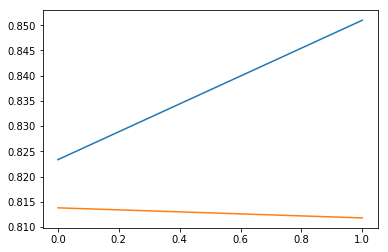

In [33]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['binary_accuracy'])
plt.plot (hist.history['val_binary_accuracy'])

## load the best weight

In [34]:
model.load_weights('./model/my2.h5')

## predict the test data

In [38]:
test_pred = model.predict([test_p, test_q, test_feature], batch_size=batch_size*2)

In [39]:
test_pred = np.squeeze(test_pred)
print(test_pred.shape)

(29997,)


## Write the array into csv file

In [40]:
res = pd.DataFrame({'id':test['id'], 'passage':test['passage'], 'query':test['query'], 'option':test['option'], 'label':test_pred})
res.to_csv('./result/test2_long.csv', index=False, encoding='utf-8_sig')